In [1]:
#Importing relevant libraries
import numpy as np
import pandas as pd
import torch
from collections import Counter

import random
import os
import re
import json
import nltk

In [4]:
# How to obtain pos_tag_info_universal.json


# def get_provo_data(input_data):
#     """A function that takes all .json files we created with info for the Provo Corpus
#     and merges it into one dictionary"""
    
#     #We merge all information in one dictionary
#     # Each data point corresponds to all the information relevant to us for a given context in Provo Corpus
#     joint_dict = {}
    
#     count = 0
#     for filename in input_data:
#         f = open(filename)
#         data = json.load(f)
#         f.close()

#         for text_id in data.keys():
#             if (int(text_id) > 0) & (int(text_id) <= 55):
#                 for word_num in data[text_id].keys():
#                     joint_dict[count] = data[text_id][word_num]
#                     joint_dict[count]['original_positioning'] = {'text_id':text_id, 'word_num':word_num}
                
#                     count = count + 1

#     return joint_dict

# os.chdir(os.path.join(os.getcwd(), 'output/data_preprocessing_words'))

# input_data = ['Paragraphs-1-1.json', 'Paragraphs-2-2.json', 'Paragraphs-3-3.json',
#     'Paragraphs-4-4.json', 'Paragraphs-5-9.json', 'Paragraphs-10-14.json', 
#     'Paragraphs-15-19.json', 'Paragraphs-20-24.json', 'Paragraphs-25-29.json',
#     'Paragraphs-30-34.json', 'Paragraphs-35-39.json', 'Paragraphs-40-44.json', 
#     'Paragraphs-45-47.json', 'Paragraphs-48-50.json', 'Paragraphs-51-53.json',
#      'Paragraphs-54-55.json']

# d = get_provo_data(input_data)

# human_samples = []
# human_samples_pos_tags = []

# original_corpus_words = []
# gpt2_samples = []
# gpt2_samples_pos_tags = []

# contexts = []

# for key in d.keys():
#     context = d[key]['context']['text']
#     contexts.append(context)
#     human_samp= [[x['pred']]*int(x['count']) for x in d[key]['human']]
#     human_samp = [str(item) for sublist in human_samp for item in sublist]
#     human_pos_tags = [nltk.pos_tag(nltk.word_tokenize(context.lower() + ' ' + sample.lower()), tagset='universal')[-1] for sample in human_samp]

#     original_word = d[key]['original']['pred']

#     gpt2_samp = [x for x in d[key]['ancestral_samples'] if x != 'Failed to generate word']
#     gpt2_samp = [[x['pred']]*int(x['count']) for x in gpt2_samp]
#     gpt2_samp = [str(item) for sublist in gpt2_samp for item in sublist]
#     gpt2_pos_tags = [nltk.pos_tag(nltk.word_tokenize(context.lower() + ' ' + sample.lower()), tagset='universal')[-1] for sample in gpt2_samp]

#     human_samples.append(human_samp)
#     gpt2_samples.append(gpt2_samp)
#     original_corpus_words.append([original_word])
#     human_samples_pos_tags.append(human_pos_tags)
#     gpt2_samples_pos_tags.append(gpt2_pos_tags)

# info = {'human_samples' : human_samples,
#         'human_samples_pos_tags' : human_samples_pos_tags,
#         'original_corpus_words' : original_corpus_words,
#         'gpt2_samples' : gpt2_samples,
#         'gpt2_samples_pos_tags' : gpt2_samples_pos_tags}

# import json

# with open("pos_tags_info_universal.json", "w") as fp:
#     json.dump(info, fp) 

In [2]:
f = open('pos_tags_info_universal.json')
 
# returns JSON object as 
# a dictionary
info = json.load(f)

In [3]:
human_samples = info['human_samples'] 
human_samples_pos_tags = info['human_samples_pos_tags']
original_corpus_words = info['original_corpus_words']
gpt2_samples = info['gpt2_samples']
gpt2_samples_pos_tags = info['gpt2_samples_pos_tags']

In [4]:
def get_estimator(elements):
    c = Counter(elements)
    support = list(c.keys())
    counts = list(c.values())
    probs = [count / sum(counts) for count in counts]

    return (support, probs)

def get_common_support(support1, support2):
    return set(support1).union(set(support2)) 

def change_support(old_support, old_probs, new_support):
    """Adding elements to a support (and their probability value is hence 0)"""
    new_probs = []
    for item in new_support:
        if item in old_support:
            ind = old_support.index(item)
            new_probs.append(old_probs[ind])
        else:
            new_probs.append(0)
    return list(new_support), new_probs

def get_tvd(probs1, probs2):
    tvd = np.sum(np.abs(np.array(probs1) - np.array(probs2)))/2
    return tvd

def get_oracle_elements(words, seed = 0, N = 20):
    """We create two disjoint subsets of the human distribution by sampling without replacement from
    the human distribution (the two disjoing subsets can be comprised by either 10 or 20 samples"""
    random.seed(seed)

    #if the length of the list is odd, we remove one element at random to make the list even,
    #since we want the two disjoint subsets to be of equal length
    if (len(words) % 2 == 1): 
        remove_word = random.sample(words, 1)
        words.remove(remove_word[0])

    #We sample the words that will belong in the first subset and create the second subset by removing
    #from the full word list the ones sampled in the first subset
    subset1 = random.sample(words, N)
    if N == 20:
        subset2 = words.copy()
        for item in subset1:
            subset2.remove(item)
    elif N == 10:
        subset_left = words.copy()
        for item in subset1:
            subset_left.remove(item)
        subset2 = random.sample(subset_left, N)
        
    return subset1, subset2

In [5]:
tvd_model_human = []
tvd_oracle1_oracle2 = []

for i in range(len(gpt2_samples_pos_tags)):
    support_model, probs_model = get_estimator([item[1] for item in gpt2_samples_pos_tags[i]])
    support_human, probs_human = get_estimator([item[1] for item in human_samples_pos_tags[i]])
    new_support = get_common_support(support_model, support_human)
    support_model, probs_model = change_support(support_model, probs_model, new_support)
    support_human, probs_human = change_support(support_human, probs_human, new_support)
    tvd_model_human.append(get_tvd(probs_model, probs_human))

    oracle1, oracle2 = get_oracle_elements([item[1] for item in human_samples_pos_tags[i]], seed = 0, N = 20)
    support_oracle1, probs_oracle1 = get_estimator(oracle1)
    support_oracle2, probs_oracle2 = get_estimator(oracle2)
    new_support = get_common_support(support_oracle1, support_oracle2)
    support_oracle1, probs_oracle1 = change_support(support_oracle1, probs_oracle1, new_support)
    support_oracle2, probs_oracle2 = change_support(support_oracle2, probs_oracle2, new_support)
    tvd_oracle1_oracle2.append(get_tvd(probs_oracle1, probs_oracle2))

In [7]:
bins = np.histogram_bin_edges(np.concatenate([tvd_model_human, tvd_oracle1_oracle2]), bins=20)

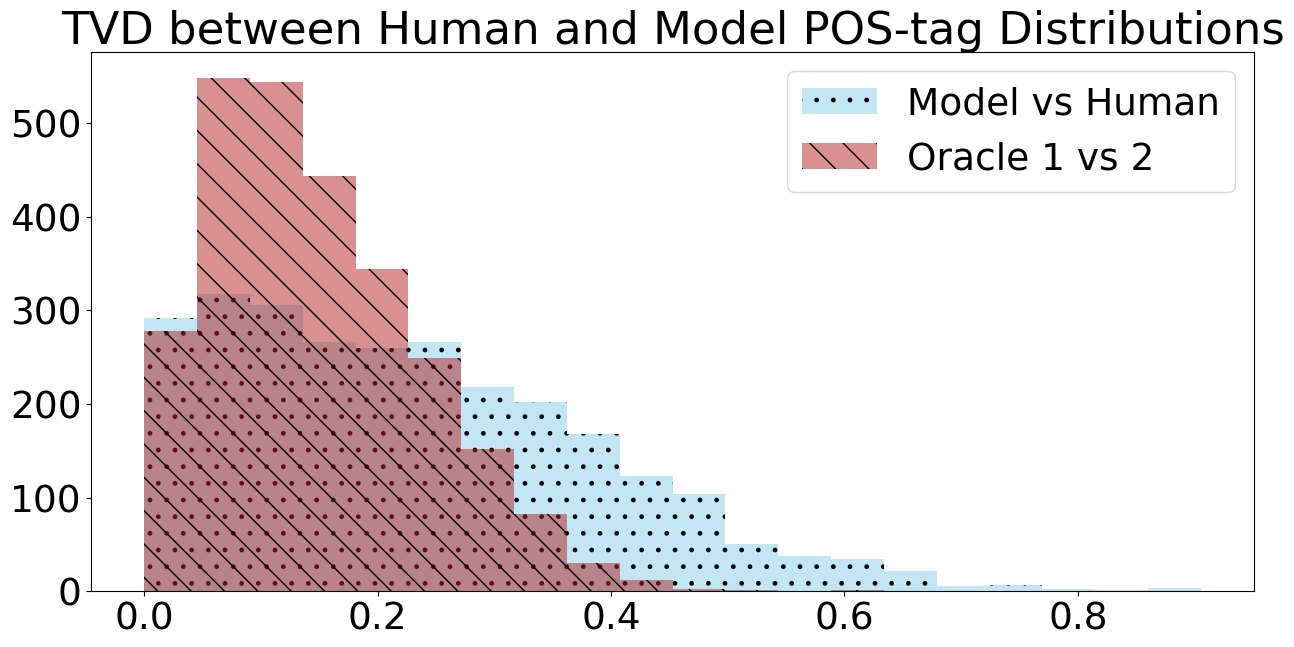

In [8]:
import matplotlib.pyplot as plt
plt.rc('font', size=27)
plt.subplots(figsize=(15, 7))
plt.hist(tvd_model_human, bins=bins, alpha=0.5, label='Model vs Human', color='Skyblue', hatch='.')
plt.hist(tvd_oracle1_oracle2, bins=bins, alpha=0.5, label='Oracle 1 vs 2', color='firebrick', hatch='\\')
plt.legend(fontsize="27", loc = 'upper right')
plt.title('TVD between Human and Model POS-tag Distributions')
plt.savefig('TVDsyntactic.pdf', format="pdf",bbox_inches='tight')

plt.show()